# Using the SavedModel format

A SavedModel contains a complete TensorFlow program, including weights and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying (with [TFLite](https://tensorflow.org/lite), [TensorFlow.js](https://js.tensorflow.org/), [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/tutorials/Serving_REST_simple), or [TensorFlow Hub](https://tensorflow.org/hub)).

This document dives into some of the details of how to use the low-level `tf.saved_model` api:

- If you are using a `tf.keras.Model` the `keras.Model.save(output_path)` method may be all you need: See the [Keras save and serialize](keras/save_and_serialize.ipynb)

- If you just want to save/load weights during training see the [guide to training checkpoints](./checkpoint.ipynb).


## Creating a SavedModel from Keras

For a quick introduction, this section exports a pre-trained Keras model and serves image classification requests with it. The rest of the guide will fill in details and discuss other ways to create SavedModels.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

65536/61306 [================================] - 0s 1us/step


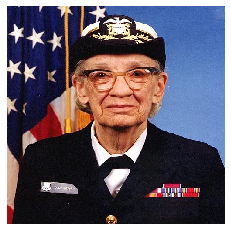

In [3]:
file = tf.keras.utils.get_file(
    "grace_hopper.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")
img = tf.keras.preprocessing.image.load_img(file, target_size=[224, 224])
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img)
x = tf.keras.applications.mobilenet.preprocess_input(
    x[tf.newaxis,...])

We'll use an image of Grace Hopper as a running example, and a Keras pre-trained image classification model since it's easy to use. Custom models work too, and are covered in detail later.

In [4]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [5]:
pretrained_model = tf.keras.applications.MobileNet()
result_before_save = pretrained_model(x)

decoded = imagenet_labels[np.argsort(result_before_save)[0,::-1][:5]+1]

print("Result before saving:\n", decoded)

17227776/17225924 [==============================] - 23s 1us/step
Result before saving:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


The top prediction for this image is "military uniform".

In [6]:
tf.saved_model.save(pretrained_model, "/tmp/mobilenet/1/")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/mobilenet/1/assets


The save-path follows a convention used by TensorFlow Serving where the last path component (`1/` here) is a version number for your model - it allows tools like Tensorflow Serving to reason about the relative freshness.

SavedModels have named functions called signatures. Keras models export their forward pass under the `serving_default` signature key. The [SavedModel command line interface](#saved_model_cli) is useful for inspecting SavedModels on disk:

In [7]:
!saved_model_cli show --dir /tmp/mobilenet/1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['act_softmax'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1000)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


We can load the SavedModel back into Python with `tf.saved_model.load` and see how Admiral Hopper's image is classified.

In [8]:
loaded = tf.saved_model.load("/tmp/mobilenet/1/")
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


Imported signatures always return dictionaries.

In [9]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'act_softmax': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='act_softmax')}


Running inference from the SavedModel gives the same result as the original model.

In [10]:
labeling = infer(tf.constant(x))[pretrained_model.output_names[0]]

decoded = imagenet_labels[np.argsort(labeling)[0,::-1][:5]+1]

print("Result after saving and loading:\n", decoded)

Result after saving and loading:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


## Running a SavedModel in TensorFlow Serving

SavedModels are usable from Python (more on that below), but production environments typically use a dedicated service for inference without running Python code. This is easy to set up from a SavedModel using TensorFlow Serving.

See the [TensorFlow Serving REST tutorial](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple) for more details about serving, including instructions for installing `tensorflow_model_server` in a notebook or on your local machine. As a quick sketch, to serve the `mobilenet` model exported above just point the model server at the SavedModel directory:

```bash
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=mobilenet \
  --model_base_path="/tmp/mobilenet" >server.log 2>&1
```

  Then send a request.

```python
!pip install -q requests
import json
import numpy
import requests
data = json.dumps({"signature_name": "serving_default",
                   "instances": x.tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/mobilenet:predict',
                              data=data, headers=headers)
predictions = numpy.array(json.loads(json_response.text)["predictions"])
```

The resulting `predictions` are identical to the results from Python.

## The SavedModel format on disk

A SavedModel is a directory containing serialized signatures and the state needed to run them, including variable values and vocabularies.


In [11]:
!ls /tmp/mobilenet/1

assets	saved_model.pb	variables


The `saved_model.pb` file stores the actual TensorFlow program, or model, and a set of named signatures, each identifying a function that accepts tensor inputs and produces tensor outputs.

SavedModels may contain multiple variants of the model (multiple `v1.MetaGraphDefs`, identified with the `--tag_set` flag to `saved_model_cli`), but this is rare. APIs which create multiple variants of a model include [`tf.Estimator.experimental_export_all_saved_models`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#experimental_export_all_saved_models) and in TensorFlow 1.x `tf.saved_model.Builder`.

In [12]:
!saved_model_cli show --dir /tmp/mobilenet/1 --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


The `variables` directory contains a standard training checkpoint (see the [guide to training checkpoints](./checkpoint.ipynb)).

In [13]:
!ls /tmp/mobilenet/1/variables

variables.data-00000-of-00001  variables.index


The `assets` directory contains files used by the TensorFlow graph, for example text files used to initialize vocabulary tables. It is unused in this example.

SavedModels may have an `assets.extra` directory for any files not used by the TensorFlow graph, for example information for consumers about what to do with the SavedModel. TensorFlow itself does not use this directory.

## Exporting custom models

In the first section, `tf.saved_model.save` automatically determined a signature for the `tf.keras.Model` object. This worked because Keras `Model` objects have an unambiguous method to export and known input shapes. `tf.saved_model.save` works just as well with low-level model building APIs, but you will need to indicate which function to use as a signature if you're planning to serve a model.

In [14]:
class CustomModule(tf.Module):

  def __init__(self):
    super(CustomModule, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function
  def __call__(self, x):
    return x * self.v

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def mutate(self, new_v):
    self.v.assign(new_v)

module = CustomModule()

This module has two methods decorated with `tf.function`. While these functions will be included in the SavedModel and available if the SavedModel is reloaded via `tf.saved_model.load` into a Python program, without explicitly declaring the serving signature tools like Tensorflow Serving and `saved_model_cli` cannot access them.

The `mutate` method has a declared `input_signature`, and so there is enough information to save its computation graph in the SavedModel already. The `__call__` method has no declared signature, and so its signature(s) are inferred from how it has been used before saving: Calling the method one or more times will create computation graphs for each particular combination of the tensor shapes and dtypes seen in the arguments. (The [tf.function](../tutorials/customization/performance.ipynb#tracing) tutorial calls that *tracing* the function.)


In [15]:
module(tf.constant(0.))
tf.saved_model.save(module, "/tmp/module_no_signatures")

INFO:tensorflow:Assets written to: /tmp/module_no_signatures/assets


For functions without an `input_signature`, any input shapes used before saving will be available after loading. Since we called `__call__` with just a scalar, it will accept only scalar values.

In [16]:
imported = tf.saved_model.load("/tmp/module_no_signatures")
assert 3. == imported(tf.constant(3.)).numpy()
imported.mutate(tf.constant(2.))
assert 6. == imported(tf.constant(3.)).numpy()

The function will not accept new shapes like vectors.

```python
imported(tf.constant([3.]))
```

<pre>
ValueError: Could not find matching function to call for canonicalized inputs ((<tf.Tensor 'args_0:0' shape=(1,) dtype=float32>,), {}). Only existing signatures are [((TensorSpec(shape=(), dtype=tf.float32, name=u'x'),), {})].
</pre>

`get_concrete_function` lets you add input shapes to a function without calling it. It takes `tf.TensorSpec` objects in place of `Tensor` arguments, indicating the shapes and dtypes of inputs. Shapes can either be `None`, indicating that any shape is acceptable, or a list of axis sizes. If an axis size is `None` then any size is acceptable for that axis. (This is often used for batch size.) `tf.TensorSpecs` can also have names, which default to the function's argument keywords ("x" here).

In [17]:
module.__call__.get_concrete_function(x=tf.TensorSpec([None], tf.float32))
tf.saved_model.save(module, "/tmp/module_no_signatures")
imported = tf.saved_model.load("/tmp/module_no_signatures")
assert [3.] == imported(tf.constant([3.])).numpy()

INFO:tensorflow:Assets written to: /tmp/module_no_signatures/assets


We didn't identify any of the functions we exported as a signature, so it has none.

In [18]:
!saved_model_cli show --dir /tmp/module_no_signatures --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"


### Identifying a signature to export

To indicate that a function should be a signature, specify the `signatures` argument when saving.

In [19]:
call = module.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
tf.saved_model.save(module, "/tmp/module_with_signature", signatures=call)

INFO:tensorflow:Assets written to: /tmp/module_with_signature/assets


Notice that we first converted the `tf.function` to a `ConcreteFunction` with `get_concrete_function`. This is necessary because the function was created without a fixed `input_signature`, and so did not have a definite set of `Tensor` inputs associated with it.

In [20]:
!saved_model_cli show --dir /tmp/module_with_signature --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['x'] tensor_info:
      dtype: DT_FLOAT
      shape: unknown_rank
      name: serving_default_x:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_0'] tensor_info:
      dtype: DT_FLOAT
      shape: unknown_rank
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [21]:
imported = tf.saved_model.load("/tmp/module_with_signature")
signature = imported.signatures["serving_default"]
assert [3.] == signature(x=tf.constant([3.]))["output_0"].numpy()
imported.mutate(tf.constant(2.))
assert [6.] == signature(x=tf.constant([3.]))["output_0"].numpy()
assert 2. == imported.v.numpy()

We exported a single signature, and its key defaulted to "serving_default". To export multiple signatures, pass a dictionary.

In [22]:
@tf.function(input_signature=[tf.TensorSpec([], tf.string)])
def parse_string(string_input):
  return imported(tf.strings.to_number(string_input))

signatures = {"serving_default": parse_string,
              "from_float": imported.signatures["serving_default"]}

tf.saved_model.save(imported, "/tmp/module_with_multiple_signatures", signatures)

INFO:tensorflow:Assets written to: /tmp/module_with_multiple_signatures/assets


In [23]:
!saved_model_cli show --dir /tmp/module_with_multiple_signatures --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "from_float"
SignatureDef key: "serving_default"


`saved_model_cli` can also run SavedModels directly from the command line.

In [24]:
!saved_model_cli run --dir /tmp/module_with_multiple_signatures --tag_set serve --signature_def serving_default --input_exprs="string_input='3.'"
!saved_model_cli run --dir /tmp/module_with_multiple_signatures --tag_set serve --signature_def from_float --input_exprs="x=3."

2020-02-13 09:35:55.101567: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3292460000 Hz
2020-02-13 09:35:55.102805: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f75a90 executing computations on platform Host. Devices:
2020-02-13 09:35:55.102829: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Result for output key output_0:
6.0
2020-02-13 09:35:58.877506: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3292460000 Hz
2020-02-13 09:35:58.878101: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55006c0 executing computations on platform Host. Devices:
2020-02-13 09:35:58.878158: I tensorflow/compiler/xla/se

## Reusing SavedModels in Python

Let us look again at class `CustomModule` above, and how `module` objects of this type were saved as SavedModels and loaded back. Did you notice the call to `module(...)` without the use of signatures?

Calling `tf.saved_model.save(obj, '/path')` on objects derived from `tf.keras.Model` or `tf.Module` saves `tf.Variable` attributes as described in the [training checkpoints](./checkpoint.ipynb) tutorial: `obj` and, recursively, the objects referenced by its attributes are traversed and the `tf.Variable` attributes found on those objects have their current values saved. Likewise, the `tf.function`-decorated methods found on those objects have their computation graphs saved. However, the original Python types, Python code of methods, and Python-valued data members are lost.

Calling `obj = tf.saved_model.load('/path')` restores the saved objects (now reduced to a placeholder type), their `tf.Variable` attributes with their respective saved values, and their `tf.function`-decorated methods. Those methods can be called as before, as long as a computation graph has been saved that covers the combination of `Tensor` shapes and non-`Tensor` values used in the call. [Retracing the tf.function from Python code](../tutorials/customization/performance.ipynb#tracing) is no longer possible and will raise an exception.

The restored `tf.function`s provide a richer, more Pythonic API to the restored model than the concrete functions in the `.signatures` dict. However, this API is inaccessible to the non-Python environments that rely on signatures.

### Basic fine-tuning

Variable objects are available, and we can backprop through imported functions. That is enough to fine-tune (i.e. retrain) a SavedModel in simple cases.

In [26]:
optimizer = tf.optimizers.SGD(0.05)

def train_step():
  with tf.GradientTape() as tape:
    loss = (10. - imported(tf.constant(2.))) ** 2
  variables = tape.watched_variables()
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))
  return loss

In [27]:
for _ in range(10):
  # "v" approaches 5, "loss" approaches 0
  print("loss={:.2f} v={:.2f}".format(train_step(), imported.v.numpy()))

loss=36.00 v=3.20
loss=12.96 v=3.92
loss=4.67 v=4.35
loss=1.68 v=4.61
loss=0.60 v=4.77
loss=0.22 v=4.86
loss=0.08 v=4.92
loss=0.03 v=4.95
loss=0.01 v=4.97
loss=0.00 v=4.98


### General fine-tuning

A SavedModel from Keras provides [more details](https://github.com/tensorflow/community/blob/master/rfcs/20190509-keras-saved-model.md#serialization-details) than a plain `__call__` to address more advanced cases of fine-tuning. TensorFlow Hub recommends to provide the following of those, if applicable, in SavedModels shared for the purpose of fine-tuning:

  * If the model uses dropout or another technique in which the forward pass differs between training and inference (like batch normalization), the `__call__` method takes an optional, Python-valued `training=` argument that defaults to `False` but can be set to `True`.
  * Next to the `__call__` attribute, there are `.variable` and `.trainable_variable` attributes with the corresponding lists of variables. A variable that was originally trainable but is meant to be frozen during fine-tuning is omitted from `.trainable_variables`.
  * For the sake of frameworks like Keras that represent weight regularizers as attributes of layers or sub-models, there can also be a `.regularization_losses` attribute. It holds a list of zero-argument functions whose values are meant for addition to the total loss.

Going back to the initial MobileNet example, we can see some of those in action:

In [28]:
loaded = tf.saved_model.load("/tmp/mobilenet/1/")
print("MobileNet has {} trainable variables: {}, ...".format(
          len(loaded.trainable_variables),
          ", ".join([v.name for v in loaded.trainable_variables[:5]])))

MobileNet has 83 trainable variables: conv1/kernel:0, conv1_bn/gamma:0, conv1_bn/beta:0, conv_dw_1/depthwise_kernel:0, conv_dw_1_bn/gamma:0, ...


In [29]:
trainable_variable_ids = {id(v) for v in loaded.trainable_variables}
non_trainable_variables = [v for v in loaded.variables
                           if id(v) not in trainable_variable_ids]
print("MobileNet also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables[:3]])))

MobileNet also has 54 non-trainable variables: conv1_bn/moving_mean:0, conv1_bn/moving_variance:0, conv_dw_1_bn/moving_mean:0, ...


## Control flow in SavedModels

Anything that can go in a `tf.function` can go in a SavedModel. With [AutoGraph](./function.ipynb) this includes conditional logic which depends on Tensors, specified with regular Python control flow.

In [30]:
@tf.function(input_signature=[tf.TensorSpec([], tf.int32)])
def control_flow(x):
  if x < 0:
    tf.print("Invalid!")
  else:
    tf.print(x % 3)

to_export = tf.Module()
to_export.control_flow = control_flow
tf.saved_model.save(to_export, "/tmp/control_flow")

INFO:tensorflow:Assets written to: /tmp/control_flow/assets


In [31]:
imported = tf.saved_model.load("/tmp/control_flow")
imported.control_flow(tf.constant(-1))  # Invalid!
imported.control_flow(tf.constant(2))   # 2
imported.control_flow(tf.constant(3))   # 0

Invalid!
2
0


## SavedModels from Estimators

Estimators export SavedModels through [`tf.Estimator.export_saved_model`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#export_saved_model). See the [guide to Estimator](https://www.tensorflow.org/guide/estimator) for details.

In [32]:
input_column = tf.feature_column.numeric_column("x")
estimator = tf.estimator.LinearClassifier(feature_columns=[input_column])

def input_fn():
  return tf.data.Dataset.from_tensor_slices(
    ({"x": [1., 2., 3., 4.]}, [1, 1, 0, 0])).repeat(200).shuffle(64).batch(16)
estimator.train(input_fn)

serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
  tf.feature_column.make_parse_example_spec([input_column]))
export_path = estimator.export_saved_model(
  "/tmp/from_estimator/", serving_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpa3lzvfyt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and 

This SavedModel accepts serialized `tf.Example` protocol buffers, which are useful for serving. But we can also load it with `tf.saved_model.load` and run it from Python.

In [33]:
imported = tf.saved_model.load(export_path)

def predict(x):
  example = tf.train.Example()
  example.features.feature["x"].float_list.value.extend([x])
  return imported.signatures["predict"](
    examples=tf.constant([example.SerializeToString()]))

In [34]:
print(predict(1.5))
print(predict(3.5))

{'all_classes': <tf.Tensor: shape=(1, 2), dtype=string, numpy=array([[b'0', b'1']], dtype=object)>, 'logistic': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5732809]], dtype=float32)>, 'probabilities': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.42671916, 0.5732809 ]], dtype=float32)>, 'logits': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.2952497]], dtype=float32)>, 'class_ids': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[1]])>, 'classes': <tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'1']], dtype=object)>, 'all_class_ids': <tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[0, 1]], dtype=int32)>}
{'all_classes': <tf.Tensor: shape=(1, 2), dtype=string, numpy=array([[b'0', b'1']], dtype=object)>, 'logistic': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.24498816]], dtype=float32)>, 'probabilities': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.7550119 , 0.24498813]], dtype=float32)>, 'logits': <tf.Tensor: sha

`tf.estimator.export.build_raw_serving_input_receiver_fn` allows you to create input functions which take raw tensors rather than `tf.train.Example`s.

## Load a SavedModel in C++

The C++ version of the SavedModel [loader](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/cc/saved_model/loader.h) provides an API to load a SavedModel from a path, while allowing SessionOptions and RunOptions. You have to specify the tags associated with the graph to be loaded. The loaded version of SavedModel is referred to as SavedModelBundle and contains the MetaGraphDef and the session within which it is loaded.

```C++
const string export_dir = ...
SavedModelBundle bundle;
...
LoadSavedModel(session_options, run_options, export_dir, {kSavedModelTagTrain},
               &bundle);
```

<a id=saved_model_cli/>

## Details of the SavedModel command line interface

You can use the SavedModel Command Line Interface (CLI) to inspect and
execute a SavedModel.
For example, you can use the CLI to inspect the model's `SignatureDef`s.
The CLI enables you to quickly confirm that the input
Tensor dtype and shape match the model. Moreover, if you
want to test your model, you can use the CLI to do a sanity check by
passing in sample inputs in various formats (for example, Python
expressions) and then fetching the output.


### Install the SavedModel CLI

Broadly speaking, you can install TensorFlow in either of the following
two ways:

*  By installing a pre-built TensorFlow binary.
*  By building TensorFlow from source code.

If you installed TensorFlow through a pre-built TensorFlow binary,
then the SavedModel CLI is already installed on your system
at pathname `bin/saved_model_cli`.

If you built TensorFlow from source code, you must run the following
additional command to build `saved_model_cli`:

```
$ bazel build tensorflow/python/tools:saved_model_cli
```

### Overview of commands

The SavedModel CLI supports the following two commands on a SavedModel:

* `show`, which shows the computations available from a SavedModel.
* `run`, which runs a computation from a SavedModel.


### `show` command

A SavedModel contains one or more model variants (technically, `v1.MetaGraphDef`s), identified by their tag-sets. To serve a model, you might wonder what kind of `SignatureDef`s are in each model variant, and what are their inputs and outputs.  The `show` command let you examine the contents of the SavedModel in hierarchical order.  Here's the syntax:

```
usage: saved_model_cli show [-h] --dir DIR [--all]
[--tag_set TAG_SET] [--signature_def SIGNATURE_DEF_KEY]
```

For example, the following command shows all available tag-sets in the SavedModel:

```
$ saved_model_cli show --dir /tmp/saved_model_dir
The given SavedModel contains the following tag-sets:
serve
serve, gpu
```

The following command shows all available `SignatureDef` keys for a tag set:

```
$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve
The given SavedModel `MetaGraphDef` contains `SignatureDefs` with the
following keys:
SignatureDef key: "classify_x2_to_y3"
SignatureDef key: "classify_x_to_y"
SignatureDef key: "regress_x2_to_y3"
SignatureDef key: "regress_x_to_y"
SignatureDef key: "regress_x_to_y2"
SignatureDef key: "serving_default"
```

If there are *multiple* tags in the tag-set, you must specify
all tags, each tag separated by a comma. For example:

<pre>
$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve,gpu
</pre>

To show all inputs and outputs TensorInfo for a specific `SignatureDef`, pass in
the `SignatureDef` key to `signature_def` option. This is very useful when you
want to know the tensor key value, dtype and shape of the input tensors for
executing the computation graph later. For example:

```
$ saved_model_cli show --dir \
/tmp/saved_model_dir --tag_set serve --signature_def serving_default
The given SavedModel SignatureDef contains the following input(s):
  inputs['x'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: x:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['y'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: y:0
Method name is: tensorflow/serving/predict
```

To show all available information in the SavedModel, use the `--all` option.
For example:

<pre>
$ saved_model_cli show --dir /tmp/saved_model_dir --all
MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['classify_x2_to_y3']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: x2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: y3:0
  Method name is: tensorflow/serving/classify

...

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['x'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: x:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['y'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: y:0
  Method name is: tensorflow/serving/predict
</pre>


### `run` command

Invoke the `run` command to run a graph computation, passing
inputs and then displaying (and optionally saving) the outputs.
Here's the syntax:

```
usage: saved_model_cli run [-h] --dir DIR --tag_set TAG_SET --signature_def
                           SIGNATURE_DEF_KEY [--inputs INPUTS]
                           [--input_exprs INPUT_EXPRS]
                           [--input_examples INPUT_EXAMPLES] [--outdir OUTDIR]
                           [--overwrite] [--tf_debug]
```

The `run` command provides the following three ways to pass inputs to the model:

* `--inputs` option enables you to pass numpy ndarray in files.
* `--input_exprs` option enables you to pass Python expressions.
* `--input_examples` option enables you to pass `tf.train.Example`.

#### `--inputs`

To pass input data in files, specify the `--inputs` option, which takes the
following general format:

```bsh
--inputs <INPUTS>
```

where *INPUTS* is either of the following formats:

*  `<input_key>=<filename>`
*  `<input_key>=<filename>[<variable_name>]`

You may pass multiple *INPUTS*. If you do pass multiple inputs, use a semicolon
to separate each of the *INPUTS*.

`saved_model_cli` uses `numpy.load` to load the *filename*.
The *filename* may be in any of the following formats:

*  `.npy`
*  `.npz`
*  pickle format

A `.npy` file always contains a numpy ndarray. Therefore, when loading from
a `.npy` file, the content will be directly assigned to the specified input
tensor. If you specify a *variable_name* with that `.npy` file, the
*variable_name* will be ignored and a warning will be issued.

When loading from a `.npz` (zip) file, you may optionally specify a
*variable_name* to identify the variable within the zip file to load for
the input tensor key.  If you don't specify a *variable_name*, the SavedModel
CLI will check that only one file is included in the zip file and load it
for the specified input tensor key.

When loading from a pickle file, if no `variable_name` is specified in the
square brackets, whatever that is inside the pickle file will be passed to the
specified input tensor key. Otherwise, the SavedModel CLI will assume a
dictionary is stored in the pickle file and the value corresponding to
the *variable_name* will be used.


#### `--input_exprs`

To pass inputs through Python expressions, specify the `--input_exprs` option.
This can be useful for when you don't have data
files lying around, but still want to sanity check the model with some simple
inputs that match the dtype and shape of the model's `SignatureDef`s.
For example:

```bsh
`<input_key>=[[1],[2],[3]]`
```

In addition to Python expressions, you may also pass numpy functions. For
example:

```bsh
`<input_key>=np.ones((32,32,3))`
```

(Note that the `numpy` module is already available to you as `np`.)


#### `--input_examples`

To pass `tf.train.Example` as inputs, specify the `--input_examples` option.
For each input key, it takes a list of dictionary, where each dictionary is an
instance of `tf.train.Example`. The dictionary keys are the features and the
values are the value lists for each feature.
For example:

```bsh
`<input_key>=[{"age":[22,24],"education":["BS","MS"]}]`
```

#### Save output

By default, the SavedModel CLI writes output to stdout. If a directory is
passed to `--outdir` option, the outputs will be saved as `.npy` files named after
output tensor keys under the given directory.

Use `--overwrite` to overwrite existing output files.
